### <center><font color=navy> Tutorial #10 Computer- and robot-assisted surgery</font></center>
## <center><font color=navy> Segmentation III/ML Basics II</font></center>
<center>&copy; Sebastian Bodenstedt, National Center for Tumor Diseases (NCT) Dresden<br>
    <a href="https://www.nct-dresden.de/"><img src="https://www.nct-dresden.de/++theme++nct/images/logo-nct-en.svg"></a> </center>

## <center><font color=navy>Preperation</font></center>

For this tutorial, we will utilize the OpenCV, Matplotlib and NumPy:

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

We will also download some data:

## <center><font color=navy>Simple neural network example</font></center>

In [2]:
import urllib.request
from os.path import basename, exists

def download(url): #download and extract Zip archive
    file_path = basename(url)
    if not exists(file_path): # does zip file already exist?
        urllib.request.urlretrieve(url, file_path) # if not, download it

In [ ]:
download("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv")
download("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names")
download("http://tso.ukdd.de/crs/model0049.th")
download("http://tso.ukdd.de/crs/img1.png")
download("http://tso.ukdd.de/crs/img2.png")
download("http://tso.ukdd.de/crs/img3.png")
download("http://tso.ukdd.de/crs/img4.png")

Import dataset

In [4]:
data = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")

Show the readme

In [5]:
f = open("pima-indians-diabetes.names", "r")
lines = f.readlines()
for l in lines:
    print(l[:-1])
f.close()

1. Title: Pima Indians Diabetes Database

2. Sources:
   (a) Original owners: National Institute of Diabetes and Digestive and
                        Kidney Diseases
   (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
                          Research Center, RMI Group Leader
                          Applied Physics Laboratory
                          The Johns Hopkins University
                          Johns Hopkins Road
                          Laurel, MD 20707
                          (301) 953-6231
   (c) Date received: 9 May 1990

3. Past Usage:
    1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
       Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
       the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
       on Computer Applications and Medical Care} (pp. 261--265).  IEEE
       Computer Society Press.

       The diagnostic, binary-valued variable investigated is whether the
       patien

Let's divide the dataset into training and testing batches

In [6]:
x = data[:, :8]
y = data[:, 8]

x_train = x[:700].astype(np.float32)
y_train = y[:700].astype(np.float32)

x_test = x[700:].astype(np.float32)
y_test = y[700:].astype(np.float32)

Now, let's construct a simple neural network to classify the samples:

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__() # Call constructur of parent class
        
        self.fc1 = nn.Linear(8, 10) # Create a fully-connected (linear) input layer with 8 inputs and 10 outputs
        #self.fc2 = nn.Linear(10, 10) # Create a fully-connected (linear) hidden layer with 10 inputs and 10 outputs
        self.fc3 = nn.Linear(10, 1) # Create a fully-connected (linear) output layer with 10 inputs and 1 output
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        #x = self.fc2(x)
        #x = torch.sigmoid(x)
        
        x = self.fc3(x)
        return torch.sigmoid(x)

Note: Other non-linearities than Sigmoid exist in pytorch, e.g.:

In [8]:
x = torch.rand(10, 10)

print(torch.sigmoid(x))
print(torch.relu(x))
print(torch.tanh(x))
print(torch.softmax(x, dim=1)) # Generally only used for last layer in classification tasks

tensor([[0.6410, 0.6459, 0.5232, 0.7270, 0.6021, 0.6343, 0.7014, 0.7021, 0.5309,
         0.6463],
        [0.5017, 0.6336, 0.5478, 0.6679, 0.6868, 0.6017, 0.5851, 0.6095, 0.6428,
         0.5599],
        [0.5123, 0.6883, 0.7168, 0.5025, 0.5978, 0.7063, 0.6925, 0.6400, 0.7091,
         0.5201],
        [0.5351, 0.5967, 0.6309, 0.7040, 0.6609, 0.6624, 0.5814, 0.7102, 0.6399,
         0.6119],
        [0.5424, 0.6467, 0.6002, 0.7230, 0.5328, 0.6380, 0.5616, 0.7012, 0.6274,
         0.6448],
        [0.6965, 0.6165, 0.7124, 0.6983, 0.5009, 0.6231, 0.5112, 0.6531, 0.5510,
         0.6214],
        [0.6826, 0.5240, 0.6604, 0.6978, 0.6204, 0.6361, 0.5953, 0.6323, 0.6789,
         0.6065],
        [0.5873, 0.5002, 0.5075, 0.7160, 0.7014, 0.6223, 0.6269, 0.6054, 0.5983,
         0.7213],
        [0.5393, 0.6411, 0.5234, 0.5507, 0.6618, 0.6099, 0.5729, 0.6246, 0.7147,
         0.5159],
        [0.6765, 0.5687, 0.7250, 0.6465, 0.5291, 0.6819, 0.5011, 0.7264, 0.6792,
         0.5687]])
tensor([[

We divide the dataset in so-called "Batches". We perform the back-propagation step and the gradient descent step for each batch separately, reducing the memory footprint and speeding up calculation.

In [9]:
batch_size = 50

num_train_batches = math.ceil(x_train.shape[0]/batch_size)
num_test_batches = math.ceil(x_test.shape[0]/batch_size)

x_train_batches = np.array_split(x_train, num_train_batches, 0)
y_train_batches = np.array_split(y_train, num_train_batches, 0)

x_test_batches = np.array_split(x_test, num_test_batches, 0)
y_test_batches = np.array_split(y_test, num_test_batches, 0)

Furthermore, we need to define a cost function. As we are performing binary classification, we will utilize cross-entropy:

In [10]:
criterion = nn.BCELoss()

We also have to decide whether we could like to use the GPU or the CPU:

In [12]:
use_gpu = True

# device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
device = "mps"

print(device)

mps


We also initialize our model:

In [13]:
model = Network()
model = model.to(device)

Next, we define the optimizer. The optimizer performs the gradient step for us. Here, we utilize so-called "Stochastic Gradient Descent". We also have to specify the step size for gradient descent, the so-called learning rate:

In [14]:
learning_rate = 5e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

We then define a training function, which iterates through all batches, converts the data into pytorch data types, puts the data through the network and finally performs the backpropagation and gradient descent.

In [15]:
def training_step(model, x, y, loss, optimizer):
    model.train()
    accuracy = 0
    losses = []
    
    count = 0
    
    for i in range(len(x)):
        optimizer.zero_grad()
        
        x_tensor = torch.from_numpy(x[i]).to(device)
        y_tensor = torch.from_numpy(y[i]).to(device)
        
        output = model(x_tensor)
        output = output.squeeze(1)
        
        loss = criterion(output, y_tensor)
        
        loss.backward()
        
        optimizer.step()
        
        prediction = torch.round(output)
        
        accuracy += torch.sum(prediction == y_tensor).item()
        losses.append(loss.item())
        
        count += x_tensor.shape[0]
        
    return np.mean(losses), accuracy/count

We also define a validation function that we can use to simply test the model on data, without modifying the model

In [16]:
def validation_step(model, x, y, loss):
    model.eval()
    accuracy = 0
    losses = []
    
    count = 0
    
    with torch.no_grad():
        for i in range(len(x)):
            x_tensor = torch.from_numpy(x[i]).to(device)
            y_tensor = torch.from_numpy(y[i]).to(device)

            output = model(x_tensor)
            output = output.squeeze(1)

            loss = criterion(output, y_tensor)

            prediction = torch.round(output)

            accuracy += torch.sum(prediction == y_tensor).item()
            losses.append(loss.item())

            count += x_tensor.shape[0]
        
    return np.mean(losses), accuracy/count

Let's see how an untrained model performs:

In [17]:
train_loss, train_accuracy = validation_step(model, x_train_batches, y_train_batches, criterion)
val_loss, val_accuracy = validation_step(model, x_test_batches, y_test_batches, criterion)

print("Error before training: train loss %.03f accuracy %.03f, validation loss %.03f accuracy %.03f" % (train_loss, train_accuracy, val_loss, val_accuracy))

Error before training: train loss 0.678 accuracy 0.599, validation loss 0.683 accuracy 0.544


Now, we try to train the model for a couple of iterations (so called epochs):

In [18]:
num_epochs = 2000

for e in range(num_epochs):
    train_loss, train_accuracy = training_step(model, x_train_batches, y_train_batches, criterion, optimizer)
    val_loss, val_accuracy = validation_step(model, x_test_batches, y_test_batches, criterion)
    if e % 100 == 0:
        print("Epoch %d: train loss %.03f accuracy %.03f, validation loss %.03f accuracy %.03f" % (e + 1, train_loss, train_accuracy, val_loss, val_accuracy))

Epoch 1: train loss 0.676 accuracy 0.607, validation loss 0.678 accuracy 0.559
Epoch 101: train loss 0.635 accuracy 0.656, validation loss 0.683 accuracy 0.603
Epoch 201: train loss 0.624 accuracy 0.656, validation loss 0.677 accuracy 0.603
Epoch 301: train loss 0.604 accuracy 0.656, validation loss 0.659 accuracy 0.603
Epoch 401: train loss 0.589 accuracy 0.691, validation loss 0.648 accuracy 0.632
Epoch 501: train loss 0.577 accuracy 0.686, validation loss 0.646 accuracy 0.632
Epoch 601: train loss 0.567 accuracy 0.721, validation loss 0.643 accuracy 0.647
Epoch 701: train loss 0.562 accuracy 0.733, validation loss 0.641 accuracy 0.647
Epoch 801: train loss 0.558 accuracy 0.731, validation loss 0.640 accuracy 0.647
Epoch 901: train loss 0.556 accuracy 0.733, validation loss 0.639 accuracy 0.647
Epoch 1001: train loss 0.554 accuracy 0.731, validation loss 0.639 accuracy 0.647
Epoch 1101: train loss 0.552 accuracy 0.731, validation loss 0.639 accuracy 0.662
Epoch 1201: train loss 0.551

Try out changing a few parameters/adjusting the architecture!

## <center><font color=navy>Image processing example</font></center>

As a next example, we will attempted to classify handwritten digits from the MNIST dataset. Luckily, pytorch already provides functionalities for directly loading the data:

In [19]:
batch_size = 100 # The DataLoader will already partition the dataset into batches for us!

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



(1, 28, 28) torch.Size([100, 1, 28, 28])
Label tensor(5)


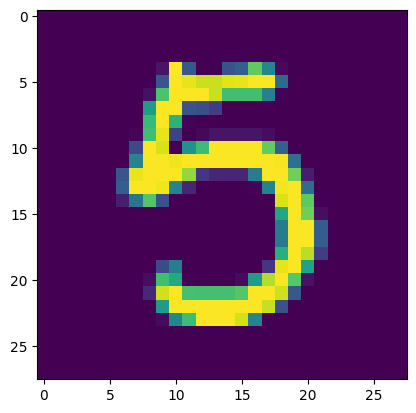

In [20]:
for data, target in train_loader:
    img = data[0].numpy()
    print(img.shape, data.shape)
    plt.imshow(img[0])
    print("Label", target[0])
    break

Next, we try to train a convolutional neural network (CNN) to recognize digits:

In [21]:
class Network_MNIST_CNN(nn.Module):
    def __init__(self):
        super(Network_MNIST_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.fc1 = nn.Linear(2880, 10)

    def forward(self, x):
        x = self.conv1(x)  #50x1x28x28 => 50x20x24x24
        x = F.max_pool2d(x, 2) #pool: 50x20x24x24 => 50x20x12x12
        x = torch.sigmoid(x)
        x = x.view(-1, 2880) #50x20x12x12 => 50x2880
        x = self.fc1(x) #50x2880 => 50x10
        return x

Again, we setup the model, the cost function and the optimizer. Because we have more than two outputs, we use categorical cross-entropy. Note: In Pytorch, the function for categorical cross-entropy already includes the softmax, so no need to include it again!

In [22]:
criterion = nn.CrossEntropyLoss()

model = Network_MNIST_CNN()
model = model.to(device)

learning_rate = 1e-1#

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

We again create two functions for training and for validation

In [26]:
def training_step(model, dataloader, loss, optimizer):
    model.train()
    accuracy = 0
    losses = []
    
    count = 0
    
    for data, target in dataloader:
        optimizer.zero_grad()
        
        x_tensor = data.to(device)
        y_tensor = target.to(device)
        
        output = model(x_tensor)
        output = output.squeeze(1)
        
        loss = criterion(output, y_tensor)
        
        loss.backward()
        
        optimizer.step()
        
        prediction = torch.argmax(output, dim=1)
        
        accuracy += torch.sum(prediction == y_tensor).item()
        losses.append(loss.item())
        
        count += x_tensor.shape[0]
        
    return np.mean(losses), accuracy/count

@torch.no_grad()    
def validation_step(model, dataloader, loss):
    model = model.eval()
    
    losses = []
    accuracy = []
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        output = model(x)
        output = output.squeeze(1)
        losses.append(loss(output, y))
    
        prediction = torch.round(output)
        acc = torch.sum(prediction == y).item()
        accuracy.append(acc)
        
    return sum(losses)/len(losses), sum(accuracy)/len(accuracy)

We then train the model (note: can be slow on CPU!):

In [27]:
num_epochs = 25

for e in range(num_epochs):
    train_loss, train_accuracy = training_step(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validation_step(model, test_loader, criterion)
    if e % 100 == 0:
        print("Epoch %d: train loss %.03f accuracy %.03f, validation loss %.03f accuracy %.03f" % (e + 1, train_loss, train_accuracy, val_loss, val_accuracy))

RuntimeError: The size of tensor a (10) must match the size of tensor b (100) at non-singleton dimension 1

Try adjusting the architecture/parameters!

Let's try to create a fully-connected network that solves the same problem:

In [ ]:
class Network_MNIST_FC(nn.Module):
    def __init__(self):
        super(Network_MNIST_FC, self).__init__()
        #TODO

    def forward(self, x):
        x = x.view(-1, 784) #50x1x28x28 => 50x784
        #TODO

        return x

And then train it:

In [2]:
#TODO Train model! Try out changing parameters

## <center><font color=navy>Segmentation example</font></center>
We will use a pretrained segmentation network (DeepLabV3) for liver segmentation and apply it to some images. First we initialize the model and load the pretrained parameters:

In [ ]:
model = models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True)
model.classifier = DeepLabHead(2048, 2)

model.load_state_dict(torch.load("model0049.th"), strict=False)
model.eval()
model = model.to(device)

We then load an image from drive, preprocesses it and convert it into a pytorch tensor

In [ ]:
image_size = (640, 512)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
     [transforms.ToTensor(),
     normalize])

In [ ]:
img = cv2.imread("img1.png")
img = cv2.resize(img, image_size)

img_tensor = transform(img).to(device)
img_tensor = img_tensor.unsqueeze(0)

plt.imshow(img[:, :, ::-1])

We then feed the data into the model and visualize the output:

In [ ]:
with torch.no_grad():
  outputs = model(img_tensor)

  pred = torch.argmax(outputs['out'], 1)

pred_numpy = pred.cpu().numpy()

plt.imshow(pred_numpy[0])